In [ ]:
# carregando os pacotes e removendo os avisos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
from prophet import Prophet
from datetime import datetime
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
base = pd.read_csv('/content/household_power_consumption.txt', delimiter=';', on_bad_lines='skip')


In [ ]:
# Verifica o shape da base
# São 2 milhões registros e 9 atributos
base.shape

(2075259, 9)

In [ ]:
# Verifica se há valores nulos
base.isnull().values.any()

True

In [ ]:
# Contagem de valores nulos

print("Ao todos temos um total de ",base.isnull().values.sum())
print("Isso corresponde a ", round((base.isnull().values.sum()/base.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  25979
Isso corresponde a  1.3 %
Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.


In [ ]:
# Remove registros nulos da base
# Pelo número de linhas, confirmamos que houve a remoção dos valores nulos
base = base.dropna()

# Confere dataset e número de linhas
base

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [ ]:
# Alguns valores na base estão como "?" e neste caso vamos substituir por 0
base = base.replace(to_replace = ['?'], value = [0])

In [ ]:
# Confere os valores nulos novamente

print("Ao todos temos um total de ",base.isnull().values.sum())
print("Isso corresponde a ", round((base.isnull().values.sum()/base.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 0% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  0
Isso corresponde a  0.0 %
Os registros nulos representam apenas 0% da base, dessa forma será melhor removê-los da base.


In [ ]:
# Converte as colunas que são do tipo 'object' para 'float64'
colunas_para_float = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

for coluna in colunas_para_float:
    base[coluna] = pd.to_numeric(base[coluna], errors='coerce')

# Verifica os tipos de dados após a conversão
print(base.dtypes)


Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [ ]:
# Cria coluna com o consumo doméstico total
base['total_consumo'] = base['Sub_metering_1'] + base['Sub_metering_2'] + base['Sub_metering_3']

# Confere os tipos de dados
base.dtypes

,0
Date,object
Time,object
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64
total_consumo,float64


In [ ]:
base

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,18.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,19.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,18.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,18.0
...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,0.0


In [ ]:
# Cópia da base para análise exploratória
df = base

In [ ]:
# Data como index da base
df = df.set_index('Date')

# Confere dataset e número de linhas
df.head()

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
Date,,,,,,,,,
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,18.0
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17.0
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,19.0
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,18.0
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,18.0


Text(0.5, 0, ' ')

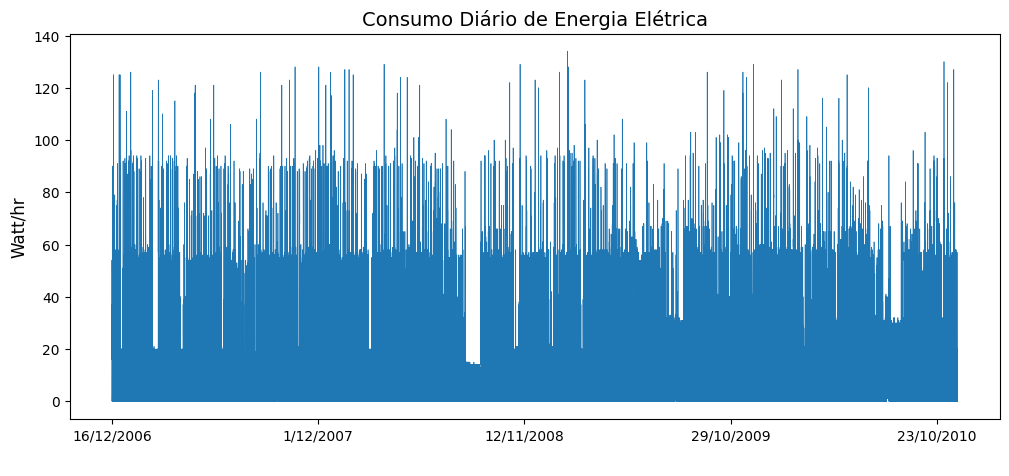

In [ ]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df['total_consumo'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Diário de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Watt/hr', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

No gráfico fica um pouco difícil analisar porque temos uma série de valores zerados, por conta disso será feito uma breve análise com a média dia de consumo.



In [ ]:
# Analise da média de consumo  por área da casa ao longo do período
# Para a análise foi selecionado Voltage e as medições por área da casa
# Para a escolha foi levado em consideração que os demais atributos de certa forma estão relacionados ao consumo global da casa
# sendo que para essa análise o ideal seria verificar com mais detalhes a base de dados

df_media = base[['Date', 'Voltage','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'total_consumo']]

# Confere o numéro de linhas e colunas
df_media

,Date,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
0,16/12/2006,234.84,0.0,1.0,17.0,18.0
1,16/12/2006,233.63,0.0,1.0,16.0,17.0
2,16/12/2006,233.29,0.0,2.0,17.0,19.0
3,16/12/2006,233.74,0.0,1.0,17.0,18.0
4,16/12/2006,235.68,0.0,1.0,17.0,18.0
...,...,...,...,...,...,...
2075254,26/11/2010,240.43,0.0,0.0,0.0,0.0
2075255,26/11/2010,240.00,0.0,0.0,0.0,0.0
2075256,26/11/2010,239.82,0.0,0.0,0.0,0.0
2075257,26/11/2010,239.70,0.0,0.0,0.0,0.0


In [ ]:
# Group by pela média do consumo diário
df_media = df_media.groupby(['Date'])[['Voltage','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','total_consumo']].mean()

# Confere o novo dataset
df_media

,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumo
Date,,,,,
1/1/2007,240.128979,0.000000,0.244444,4.083333,4.327778
1/1/2008,241.036674,1.709028,1.902083,8.579861,12.190972
1/1/2009,242.836062,0.531250,2.670139,1.946528,5.147917
1/1/2010,242.565722,1.600000,0.227083,2.470833,4.297917
1/10/2007,239.239917,1.046528,4.598611,4.138889,9.784028
...,...,...,...,...,...
9/8/2010,241.069264,0.000000,0.357639,2.806944,3.164583
9/9/2007,238.922146,1.516667,3.081944,6.411806,11.010417
9/9/2008,239.781667,0.163889,0.314583,5.366667,5.845139


Text(0.5, 0, ' ')

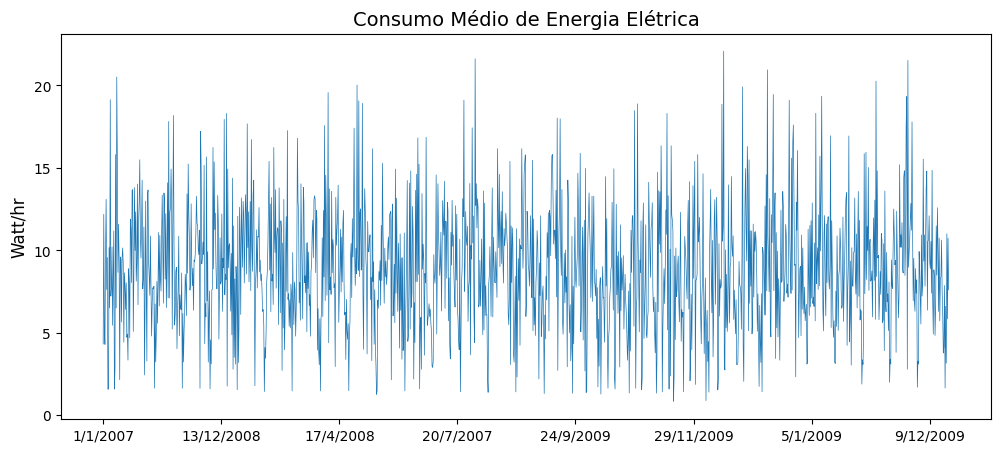

In [ ]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df_media['total_consumo'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Médio de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Watt/hr', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

No gráfico com a média de consumo diário, é possível observar que o consumo mantém o mesmo nível ao longo dos anos. Nos meses de Julho temos uma queda no consumo, talvez pelo fato de ser férias e os moradores ficarem em outros lugares e após esse mês vemos uma alta no consumo de energia elétrica.

Vale lembrar que as medições foram feitas na Europa, mais precisamente na França. Por conta da localização precisamos levar em considerar as estações, com temperaturas mais baixas a partir de dezembro e temperaturas mais altas a partir de julho. Esse aumento no consumo no final do ano pode estar relacionado ao aquecedor da casa.

## Processamento de dados para o Modelo Preditivo

In [ ]:
# Base para o modelo
# Para esse modelo, será usado a métrica com o consumo total em volts
df_modelo = base[['Date', 'Voltage']]

# Confere o numéro de linhas e colunas
df_modelo

,Date,Voltage
0,16/12/2006,234.84
1,16/12/2006,233.63
2,16/12/2006,233.29
3,16/12/2006,233.74
4,16/12/2006,235.68
...,...,...
2075254,26/11/2010,240.43
2075255,26/11/2010,240.00
2075256,26/11/2010,239.82
2075257,26/11/2010,239.70


In [ ]:
# Group by pela média do consumo diário
df_modelo = df_modelo.groupby(['Date'])[['Voltage']].mean()

# Confere o novo dataset
df_modelo

,Voltage
Date,
1/1/2007,240.128979
1/1/2008,241.036674
1/1/2009,242.836062
1/1/2010,242.565722
1/10/2007,239.239917
...,...
9/8/2010,241.069264
9/9/2007,238.922146
9/9/2008,239.781667


In [ ]:
# Converte o objeto em dataframe pandas
df_modelo = pd.DataFrame(df_modelo)

# Confere dataset e número de linhas
df_modelo

,Voltage
Date,
1/1/2007,240.128979
1/1/2008,241.036674
1/1/2009,242.836062
1/1/2010,242.565722
1/10/2007,239.239917
...,...
9/8/2010,241.069264
9/9/2007,238.922146
9/9/2008,239.781667


In [ ]:
# Reset do index para inclusão de colunas de tempo
df_modelo = df_modelo.reset_index()

# Confere dataset e número de linhas
df_modelo

,Date,Voltage
0,1/1/2007,240.128979
1,1/1/2008,241.036674
2,1/1/2009,242.836062
3,1/1/2010,242.565722
4,1/10/2007,239.239917
...,...,...
1428,9/8/2010,241.069264
1429,9/9/2007,238.922146
1430,9/9/2008,239.781667
1431,9/9/2009,241.308507


In [ ]:
# Renomeia colunas de data para ds e variável target para y
df_modelo.rename(
    columns={"Date": "ds", "Voltage": "y"},
    inplace=True,
)

# Confere as mudanças no nome das colunas
df_modelo

,ds,y
0,1/1/2007,240.128979
1,1/1/2008,241.036674
2,1/1/2009,242.836062
3,1/1/2010,242.565722
4,1/10/2007,239.239917
...,...,...
1428,9/8/2010,241.069264
1429,9/9/2007,238.922146
1430,9/9/2008,239.781667
1431,9/9/2009,241.308507


Text(0.5, 0, ' ')

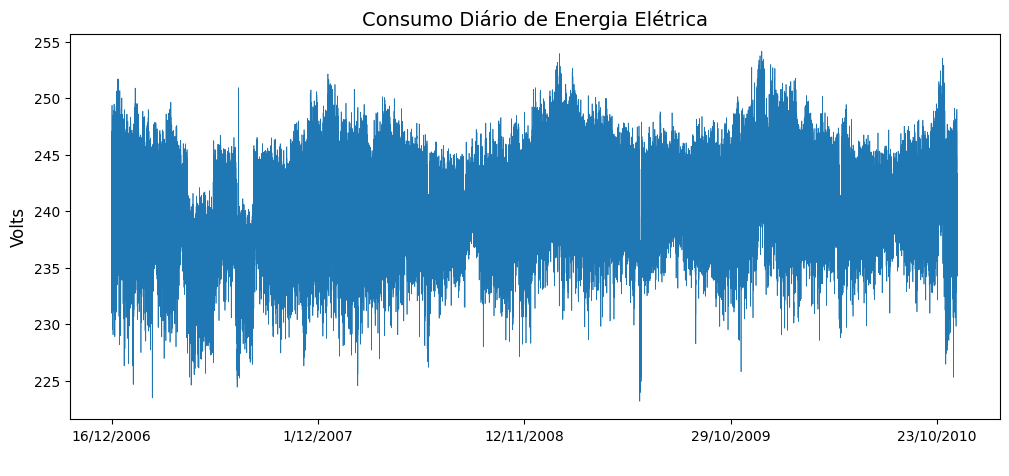

In [ ]:
# Plot da série temporal

# Ajuste no tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Define a métrica observada
df['Voltage'].plot(linewidth=0.5)

# Define título
plt.title('Consumo Diário de Energia Elétrica', fontsize = 14)

# Define nomes dos eixos X e Y
plt.ylabel('Volts', fontsize = 12)
plt.xlabel(' ', fontsize = 12)

Em relação ao atributo Voltage, que representa o consumo de energia em volts, temos um consumo constante que está em tendência de alta ao longo dos anos. O pico do consumo aconteceram no verão europeu (entre dezembro e março). Essa informação mostra que os boxplots mostraram uma tendência correta de alta entre esses meses por conta do consumo do aquecedor no inverno europeu.

## Modelo Preditivo

In [ ]:
modelo_v1 = Prophet()


In [ ]:
# Converte a coluna 'Date' para o formato datetime especificando o padrão
df_modelo['ds'] = pd.to_datetime(df_modelo['ds'], format='%d/%m/%Y')


In [ ]:
from prophet import Prophet

# Inicializa o modelo Prophet
modelo = Prophet()

# Ajusta o modelo aos dados
modelo.fit(df_modelo)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7t0368ut/rihlw6yu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7t0368ut/cnqn8vsv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24667', 'data', 'file=/tmp/tmp7t0368ut/rihlw6yu.json', 'init=/tmp/tmp7t0368ut/cnqn8vsv.json', 'output', 'file=/tmp/tmp7t0368ut/prophet_modelmsa5vm4g/prophet_model-20241119110815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:08:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:08:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Define o período para previsão (exemplo: 30 dias à frente)
futuro = modelo.make_future_dataframe(periods=30)

# Verifica o dataframe de datas futuras
futuro.tail()


,ds
82,2007-03-08
83,2007-03-09
84,2007-03-10
85,2007-03-11
86,2007-03-12


In [ ]:
# Define o período para previsão (por exemplo, 30 dias à frente)
futuro = modelo.make_future_dataframe(periods=30)

# Verifica o dataframe de datas futuras
futuro.tail()


,ds
82,2007-03-08
83,2007-03-09
84,2007-03-10
85,2007-03-11
86,2007-03-12


In [ ]:
# Gera previsões para o período futuro
previsao = modelo.predict(futuro)

# Exibe as previsões (opcional, para conferência)
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
82,2007-03-08,240.520154,236.856295,244.481638
83,2007-03-09,240.168886,236.377526,244.284771
84,2007-03-10,238.618237,234.524699,242.822817
85,2007-03-11,239.096650,234.853016,243.840183
86,2007-03-12,240.112651,235.699573,244.750772


In [ ]:
from prophet.plot import plot_plotly

# Visualiza a previsão com Plotly (gráfico interativo)
fig = plot_plotly(modelo, previsao)
fig.show()


Linha Azul: Representa a previsão feita pelo modelo Prophet para o consumo de energia elétrica, com base nos dados históricos fornecidos.

Pontos Pretos: São os dados reais observados (consumo de energia elétrica medido), que foram usados para treinar o modelo e para comparação visual com a previsão.

Área Azul-Clara: Esta área ao redor da linha azul representa o intervalo de confiança da previsão. A largura da área indica o grau de incerteza do modelo: quanto maior a largura, maior a incerteza sobre a previsão nesse ponto específico do tempo.

Painel Inferior: O painel menor na parte de baixo do gráfico permite uma visualização interativa do histórico completo e da previsão.

Interpretação do Gráfico
A previsão está capturando um padrão sazonal no consumo.
O modelo segue bem o comportamento geral dos dados históricos, mas há algumas variações nos pontos que estão fora da área de confiança. Esses podem ser dias atípicos ou picos fora do padrão esperado pelo modelo.